# Predictions for fantasy baseball

Millions of people play fantasy baseball using leagues that are typically draft- or auction-based. Choosing a team based on your favorite players&mdash;or simply on last year's performance without any regard for regression to the mean&mdash;is likely to field a weaker team. Baseball is one of the most "documented" of all sports, statistics-wise. With the wealth of collected information, you can derive a better estimate of each player's true talent level and their likely performance in the coming year using machine learning. This allows for better drafting and also helps avoid overpaying for players coming off of "career" seasons.

When drafting players for fantasy baseball, you must make decisions based on the player's performance over their career to date, as well as effects like aging. Basing evaluation on personal interpretation of the player's performance is likely to cause you to overvalue a player's most recent performance. In other words, it's common to overvalue a player coming off a career year or undervalue a player coming off a bad year. The goal is to generate a better estimate of the player's value in the next year based on what he has done in prior years. If you build a machine learning model to predict a player's performance in the next year based on their previous performance, it will help you identify when these over- or under-performances are flukes versus when they are actual indicators of that player’s future performance.

To run this notebook on your own, use the download icon in the top right of this page.

## Setup

This example assumes that the DataRobot Python client package has been installed and configured with the credentials of a DataRobot user with API access permissions. It also utilizes the `pybaseball` module, which scrapes data from Fangraphs.com, a popular baseball website with many statistics and a publicly available API. The following steps import the required libraries.

### Retrieve baseball data

This notebook uses the `pybaseball` module to get player seasons from 2012 through 2021. In this workflow, the machine learning algorithm learns patterns from pre-COVID era data as well as data from 2020 and 2021. This data should help show how well the top model is able to learn how to work around a shortened season. 

Fangraphs provides more than 300 features about players each season, from the most superficial statistics like batting average (`AVG`) and home run counts (`HR`), to the most in-depth statistics like expected weighted on-base average (`xWOBA`) and barrel contact percentage (`Barrel%`). DataRobot sifts through many of these features to find the ones that signal future performance best.

For this notebook, the focus is on predicting a batting average in the following season. Batting average is a common statistic used in all fantasy baseball league types. It is a rate statistic, rather than a total like home runs, so you can leverage many rate statistic features of players and mostly avoid volume statistics outside of plate appearances (`PA`).

### Import libraries

In [ ]:
pip install pybaseball # Only if it has not yet been installed

In [2]:
import datetime
from datetime import datetime

import datarobot as dr
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

### Import player batting data

Starting in 2007, Pitch Info Solutions started tracking some advanced pitch-by-pitch metrics for batters and pitchers, making it a good year to start the model training. 

Download the data in two chunks:

* [2007-2013 stats](batters_training_2007_2013.csv)
* [2014-2021 stats](batters_training_2014_2021.csv)

In [3]:
batters_training_2007_2013 = pd.read_csv(
    "https://docs.datarobot.com/en/docs/api/guide/common-case/batters_training_2007_2013.csv"
)

batters_training_2014_2021 = pd.read_csv(
    "https://docs.datarobot.com/en/docs/api/guide/common-case/batters_training_2014_2021.csv"
)

batters_training = pd.concat([batters_training_2007_2013, batters_training_2014_2021], axis=0)

In [4]:
batters_training.shape

(14118, 319)

### Data preparation

The snippets below create a "primary" target dataset, as well as a secondary dataset from which you derive features on each player's past performance across many statistics. Note that you may need to run the cell below multiple times.

In [5]:
batters_training["Date"] = [str(year) + "-03-01" for year in batters_training["Season"]]
batters_training["COVID"] = [1 if year == 2020 else 0 for year in batters_training["Season"]]
batters_training = batters_training[
    [  # Basic info
        "IDfg",
        "Season",
        "Name",
        "Date",
        "COVID",
        "Age",
        "PA",
        # Superficial rates
        "BB%",
        "K%",
        "AVG",
        # Expected rates based on batted ball data
        "xBA",
        "Barrel%",
        "maxEV",
        "xSLG",
        "Oppo%",
        "HR/FB",
        "IFFB%",
        # Plate discipline
        "CStr%",
        "SwStr%",
        "O-Swing% (pi)",
        "Z-Swing% (pi)",
        "O-Contact% (pi)",
        "Z-Contact% (pi)",
        "Zone% (pi)",
        # Speed + position adjustment
        "SB",
        "CS",
        "BsR",
        "Pos",
    ]
]
batters_training["SB%"] = batters_training["SB"] / (batters_training["SB"] + batters_training["CS"])
batters_training["SB/PA"] = batters_training["SB"] / (batters_training["PA"])
batters_training["BsR/PA"] = batters_training["BsR"] / (batters_training["PA"])

In [6]:
# Scale plate appearances (PA) to the season's highest total, to better adjust for COVID-shortened season
max_pa = pd.DataFrame(batters_training.groupby("Season")["PA"].max())
max_pa.rename(columns={"PA": "PA_max"}, inplace=True)
batters_training = pd.merge(batters_training, max_pa, how="left", on="Season")
batters_training["PA_scaled"] = batters_training["PA"] / batters_training["PA_max"]

In [7]:
# Use a weight so that the model can learn more from players with greater sample size
batters_training["weight"] = np.sqrt(batters_training["PA"])

In [8]:
# Create primary and secondary datasets for Feature Discovery (automated feature engineering)
batters_primary = batters_training[batters_training["Season"] > 2007][
    ["IDfg", "Date", "COVID", "Age", "weight", "AVG"]
]
batters_secondary = batters_training[
    [
        "IDfg",
        "Date",
        "COVID",
        "PA_scaled",
        "BB%",
        "K%",
        "AVG",
        "xBA",
        "Barrel%",
        "maxEV",
        "xSLG",
        "Oppo%",
        "HR/FB",
        "IFFB%",
        "CStr%",
        "SwStr%",
        "O-Swing% (pi)",
        "Z-Swing% (pi)",
        "O-Contact% (pi)",
        "Z-Contact% (pi)",
        "Zone% (pi)",
        "SB%",
        "SB/PA",
        "BsR/PA",
        "Pos",
    ]
]

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the Python client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [ ]:
# If the config file is not in the default location described in the API Quickstart guide, '~/.config/datarobot/drconfig.yaml', then you will need to call
# dr.Client(config_path='path-to-drconfig.yaml')

## Modeling with Feature Discovery

Create a DataRobot project to train many models against the assembled dataset. Then you will leverage an automated feature engineering tool in DataRobot called Feature Discovery, which will use the secondary dataset created above to derive rolling, time-aware features about players' recent performance history. In this example, DataRobot looks back up to three seasons to derive a player's recent performance, though it's worth testing longer and shorter feature derivation windows.

### Define projects settings

In [10]:
# Register secondary dataset in AI Catalog
secondary_dataset = dr.Dataset.create_from_in_memory_data(batters_secondary)

In [11]:
# Define relationships between datasets and lookback "feature derivation" windows
dataset_definitions = [
    {
        "identifier": "BA_secondary_3years",
        "catalogVersionId": secondary_dataset.version_id,
        "catalogId": secondary_dataset.id,
        # "feature_list_id": secondary_dataset_featurelist.id, # default is Informative features
        "primaryTemporalKey": "Date",
        "snapshotPolicy": "latest",
    },
    {
        "identifier": "BA_secondary_2",
        "catalogVersionId": secondary_dataset.version_id,
        "catalogId": secondary_dataset.id,
        # "feature_list_id": secondary_dataset_featurelist.id, # default is Informative features
        "primaryTemporalKey": "Date",
        "snapshotPolicy": "latest",
    },
    {
        "identifier": "BA_secondary_3",
        "catalogVersionId": secondary_dataset.version_id,
        "catalogId": secondary_dataset.id,
        # "feature_list_id": secondary_dataset_featurelist.id, # default is Informative features
        "primaryTemporalKey": "Date",
        "snapshotPolicy": "latest",
    },
]

relationships = [
    {
        "dataset2Identifier": "BA_secondary_3years",
        "dataset1Keys": ["IDfg"],
        "dataset2Keys": ["IDfg"],
        "featureDerivationWindowStart": -3,
        "featureDerivationWindowEnd": 0,
        "featureDerivationWindowTimeUnit": "YEAR",
        "predictionPointRounding": 1,
        "predictionPointRoundingTimeUnit": "SECOND",
    },
    {
        "dataset2Identifier": "BA_secondary_2",
        "dataset1Keys": ["IDfg"],
        "dataset2Keys": ["IDfg"],
        "featureDerivationWindowStart": -2,
        "featureDerivationWindowEnd": -1,
        "featureDerivationWindowTimeUnit": "YEAR",
        "predictionPointRounding": 1,
        "predictionPointRoundingTimeUnit": "SECOND",
    },
    {
        "dataset2Identifier": "BA_secondary_3",
        "dataset1Keys": ["IDfg"],
        "dataset2Keys": ["IDfg"],
        "featureDerivationWindowStart": -3,
        "featureDerivationWindowEnd": -2,
        "featureDerivationWindowTimeUnit": "YEAR",
        "predictionPointRounding": 1,
        "predictionPointRoundingTimeUnit": "SECOND",
    },
]

relationship_config = dr.RelationshipsConfiguration.create(
    dataset_definitions=dataset_definitions, relationships=relationships
)

In [17]:
# Set up specific backtest segments

# Set holdout partition full season 2021
# The 2020 season has been set with the date 2020-03-01, so start this partition on 2020-03-02
# set gap of 1 year to avoid validating on 2020 (though 2020 will still be used in final model training)
partitioning_spec = dr.DatetimePartitioningSpecification(
    datetime_partition_column="Date",
    gap_duration="P1Y",
    holdout_start_date=datetime(2020, 3, 2),
    holdout_duration="P1Y",
    number_of_backtests=2,
    use_time_series=False,
)

# Set the backtest partition--used to hyperparameter tune the models--to the non-COVID 2019 season
partitioning_spec.backtests = [
    dr.BacktestSpecification(
        0,  # backtest 1 index
        gap_duration="P0Y",
        validation_start_date=datetime(2018, 3, 2),
        validation_duration="P1Y",
    ),
    dr.BacktestSpecification(
        1,  # backtest 2 index
        gap_duration="P0Y",
        validation_start_date=datetime(2017, 3, 2),
        validation_duration="P1Y",
    ),
    # Input other backtest periods below if desired
    #     dr.BacktestSpecification(
    #       1, # backtest 2 index
    #       gap_duration = 'P0Y',
    #       validation_start_date=datetime(2018,3,2),
    #       validation_duration = 'P1Y')
]

In [13]:
# Create advanced options object with weights
advanced_options = dr.AdvancedOptions(weights="weight", consider_blenders_in_recommendation=True)

Use the snippet below to get a full explanation of the advanced options configured for the notebook.

In [14]:
?dr.AdvancedOptions

### Create project

In [15]:
EXISTING_PROJECT_ID = None # If you've already created a project, replace None with the ID here
if EXISTING_PROJECT_ID is None:
    # Create project and pass in data
    project = dr.Project.create(sourcedata = batters_primary,
                                project_name = 'Batting Average Predictions for Fantasy Baseball: 2007 - 2021'
                               dataset_filename="batters_primary")

    # Set the project target to the appropriate feature. Use the LogLoss metric to measure performance
    project.set_target(target='broken',
                       mode=dr.AUTOPILOT_MODE.QUICK, 
                       worker_count='-1')
else:
    # Fetch the existing project
    project = dr.Project.get(EXISTING_PROJECT_ID)

project.wait_for_autopilot(check_interval=30)

# The featurelist from the primary dataset effectively includes "known in advance" features
# All features from the secondary dataset will be lagged
primary_featurelist = project.create_featurelist(
      "Primary model features",
      ['COVID','Age'])

### Initiate Autopilot

In [ ]:
# Start project
project.set_target(
    target="AVG",
    mode=dr.AUTOPILOT_MODE.QUICK,
    worker_count=-1,
    advanced_options=advanced_options,
    partitioning_method=partitioning_spec,
    featurelist_id=primary_featurelist.id,
    relationships_configuration_id=relationship_config.id,
    max_wait=3600,  # allow up to an hour for pre-processing before timeout
)

### View project in UI

If you want to view the project in the DataRobot UI, use the following snippet to retrieve the project's URL and use it to navigate to the application.

In [20]:
# Get project URL
project_url = project.get_leaderboard_ui_permalink()
print(project_url)

https://app.datarobot.com/projects/62ec4628387ba15033da9153/models


In [22]:
project.wait_for_autopilot(check_interval=60)

In progress: 0, queued: 0 (waited: 0s)


## Evaluate model performance 

In order to measure model performance, first select the top-performing model based on a specific performance metric (i.e., `LogLoss`) and then evaluate several different types of charts, such as Lift Chart, ROC Curve, and Feature Importance. There are two helper functions that you need to build in order to simplify producing these model insights.

Because this project utilized time-based partitioning, there are not out-of-sample validation metrics for models fit to 100% of the data (including the recommended model). Investigate the parent of the recommended model, fit to the training data, using the following code. You can reference more information about model evaluation tools [here](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/index.html).

In [23]:
def sorted_by_metric(models, test_set, metric):
    models_with_score = [model for model in models if model.metrics[metric][test_set] is not None]

    return sorted(models_with_score, key=lambda model: model.metrics[metric][test_set])

In [24]:
# Unlock holdout and get list of models trained
project.unlock_holdout()
models = project.get_models()

# Uncomment if this is not set when creating the project
metric = project.metric

# Get the top-performing model
model_top = sorted_by_metric(models, "holdout", metric)[0]

print(
    """The top performing model is {model} using metric, {metric}""".format(
        model=str(model_top), metric=metric
    )
)

The top performing model is Model('AVG Blender') using metric, Weighted RMSE


In [25]:
# Set styling
dr_dark_blue = "#08233F"
dr_blue = "#1F77B4"
dr_orange = "#FF7F0E"
dr_red = "#BE3C28"
dr_light_blue = "#3CA3E8"

# Histogram function


def rebin_df(raw_df, number_of_bins):
    cols = ["bin", "actual_mean", "predicted_mean", "bin_weight"]
    new_df = pd.DataFrame(columns=cols)
    current_prediction_total = 0
    current_actual_total = 0
    current_row_total = 0
    x_index = 1
    bin_size = 60 / number_of_bins
    for rowId, data in raw_df.iterrows():
        current_prediction_total += data["predicted"] * data["bin_weight"]
        current_actual_total += data["actual"] * data["bin_weight"]
        current_row_total += data["bin_weight"]

        if (rowId + 1) % bin_size == 0:
            x_index += 1
            bin_properties = {
                "bin": ((round(rowId + 1) / 60) * number_of_bins),
                "actual_mean": current_actual_total / current_row_total,
                "predicted_mean": current_prediction_total / current_row_total,
                "bin_weight": current_row_total,
            }

            new_df = new_df.append(bin_properties, ignore_index=True)
            current_prediction_total = 0
            current_actual_total = 0
            current_row_total = 0
    return new_df


def matpltlib_residual(residual):
    if residual:
        validation = residuals[2]
        actual, predicted, _, _ = zip(*validation.data)
        data = {"actual": actual, "predicted": predicted}
        data_frame = pd.DataFrame(data)

        plot = data_frame.plot.scatter(
            x="actual",
            y="predicted",
            legend=False,
            color=dr_light_blue,
        )
        plot.set_facecolor(dr_dark_blue)

        # define our axes with a minuscule bit of padding
        min_x = min(data["actual"]) - 5
        max_x = max(data["actual"]) + 5
        min_y = min(data["predicted"]) - 5
        max_y = max(data["predicted"]) + 5

        biggest_value = max(abs(i) for i in [min_x, max_x, min_y, max_y])

        # plot a diagonal 1:1 line to show the "perfect fit" case
        diagonal = np.linspace(-biggest_value, biggest_value, 100)
        plt.plot(diagonal, diagonal, color="gray")

        plt.xlabel("Actual Value")
        plt.ylabel("Predicted Value")
        plt.axis("equal")
        plt.xlim(min_x, max_x)
        plt.ylim(min_y, max_y)

        plt.title("Predicted Values vs. Actual Values", y=1.04)

### Lift Chart

The [Lift Chart](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/lift-chart.html#lift-chart) shows you how close model predictions are to the actual values of the target in the training data. Lift Chart data includes the average predicted value and the average actual values of the target, sorted by the prediction values in ascending order and split into up to bins. You can select 5, 10, 15, 20, 30, or 60 bins.

The predictions shown below were generated on 2021 data (the holdout data), using a model that learned patterns from the 2012 - 2018 seasons about how a player's recent performance correlates to their next-season performance. 2021 is a tough year to predict because the season immediately prior was a COVID season. Still, the model did admirably well. 

In [26]:
# Lift chart function


def matplotlib_lift(bins_df, bin_count, ax):
    grouped = rebin_df(bins_df, bin_count)
    ax.plot(
        range(1, len(grouped) + 1),
        grouped["predicted_mean"],
        marker="+",
        lw=1,
        color=dr_blue,
        label="predicted",
    )
    ax.plot(
        range(1, len(grouped) + 1),
        grouped["actual_mean"],
        marker="*",
        lw=1,
        color=dr_orange,
        label="actual",
    )
    ax.set_xlim([0, len(grouped) + 1])
    ax.set_facecolor(dr_dark_blue)
    ax.legend(loc="best")
    ax.set_title("Lift chart {} bins".format(bin_count))
    ax.set_xlabel("Sorted Prediction")
    ax.set_ylabel("Value")
    return grouped

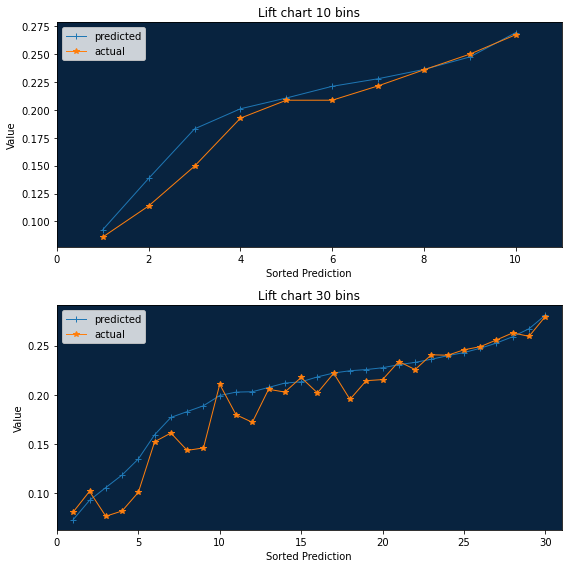

In [27]:
lift_chart = model_top.get_lift_chart("holdout")

# Save the result into a pandas dataframe
lift_df = pd.DataFrame(lift_chart.bins)

bin_counts = [10, 30]
f, axarr = plt.subplots(len(bin_counts))
f.set_size_inches((8, 4 * len(bin_counts)))

rebinned_dfs = []
for i in range(len(bin_counts)):
    rebinned_dfs.append(matplotlib_lift(lift_df, bin_counts[i], axarr[i]))

plt.tight_layout()
# plt.show()

### Feature Impact

[Feature Impact](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-impact.html) measures how important a feature is in the context of a model. It measures how much the accuracy of a model would decrease if that feature was removed.

Feature Impact is available for all model types and works by altering input data and observing the effect on a model’s score. It is an on-demand feature, meaning that you must initiate a calculation to see the results. Once DataRobot computes the feature impact for a model, that information is saved with the project.

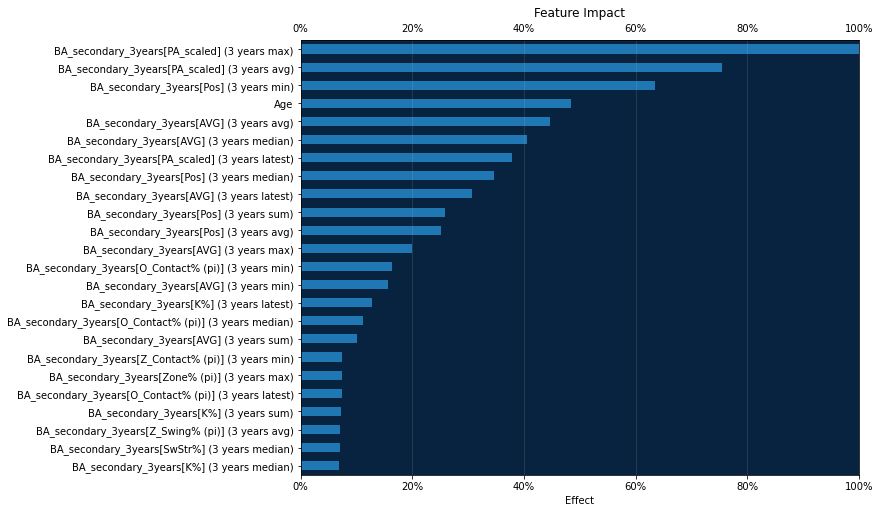

In [28]:
feature_impacts = model_top.get_or_request_feature_impact()

# Limit size to make the chart display better
# Displays the top 25 values
if len(feature_impacts) > 25:
    feature_impacts = feature_impacts[0:24]

# Formats the ticks from a float into a percent
percent_tick_fmt = mtick.PercentFormatter(xmax=1.0)

impact_df = pd.DataFrame(feature_impacts)
impact_df.sort_values(by="impactNormalized", ascending=True, inplace=True)

# Positive values are blue, negative are red
bar_colors = impact_df.impactNormalized.apply(lambda x: dr_red if x < 0 else dr_blue)

ax = impact_df.plot.barh(
    x="featureName", y="impactNormalized", legend=False, color=bar_colors, figsize=(10, 8)
)
ax.xaxis.set_major_formatter(percent_tick_fmt)
ax.xaxis.set_tick_params(labeltop=True)
ax.xaxis.grid(True, alpha=0.2)
ax.set_facecolor(dr_dark_blue)

plt.ylabel("")
plt.xlabel("Effect")
plt.xlim((None, 1))  # Allow for negative impact
plt.title("Feature Impact", y=1.04);

## Make predictions

### Test predictions

After determining the top-performing model from the Leaderboard, upload a prediction test dataset to verify that the model generates predictions successfully before deploying the model to a production environment. The predictions are returned as a Pandas dataframe. Note that this example uses two methods for creating the scoring dataset. In most cases, you'd be running this in the offseason, and you wouldn't have a definitive list of players for the following season. In that case, the second option below makes sense&mdash;taking the players from the prior season (2021) and creating a scoring dataset for 2022.

* [Download scoring data](2022_AVG_scoring_data.csv)

In [29]:
# Get recommended model
rec_model = project.recommended_model()

# Option 1: Scoring data using the current (2022) season of players (if the season has commenced)
scoring_data_2022 = batting_stats(2022, 2022, qual=1, split_seasons=True)
scoring_data_2022["Date"] = [str(year) + "-03-01" for year in scoring_data_2022["Season"]]
scoring_data_2022["COVID"] = [1 if year == 2020 else 0 for year in scoring_data_2022["Season"]]
scoring_data_2022 = scoring_data_2022[["IDfg", "Name", "Date", "COVID", "Age", "PA", "AVG"]]
scoring_data_2022["weight"] = np.sqrt(scoring_data_2022["PA"])

# Option 2: Scoring data created from the prior (2021) season of players using training data
scoring_data_2022_from_training = batters_training[batters_training["Date"] == "2021-03-01"]
scoring_data_2022_from_training = scoring_data_2022_from_training[
    ["IDfg", "Date", "COVID", "Age", "PA", "weight", "AVG"]
]
scoring_data_2022_from_training["Age"] = scoring_data_2022_from_training["Age"] + 1
scoring_data_2022_from_training["Date"] = [
    str(int(date[0:4]) + 1) + "-03-01" for date in scoring_data_2022_from_training["Date"]
]

scoring_data_2022.to_csv("2022_AVG_scoring_data.csv")
scoring_data_2022
prediction_dataset = project.upload_dataset(scoring_data_2022)
predict_job = rec_model.request_predictions(prediction_dataset.id)

predictions = predict_job.get_result_when_complete()
pd.concat([scoring_data_2022, predictions], axis=1)
predictions.positive_probability.plot(kind="hist", title="Predicted Probabilities")

IDfg           Name        Date  COVID  Age  PA  AVG    weight  row_id  \
0    19952     Khalil Lee  2022-03-01      0   24   2  0.5  1.414214       0   
1    21635     Nick Maton  2022-03-01      0   25   7  0.5  2.645751       1   
2    24770   James Outman  2022-03-01      0   25  12  0.6  3.464102       2   
3    17734  Evan Phillips  2022-03-01      0   27   1  0.0  1.000000       3   
4    20178  Miguel Vargas  2022-03-01      0   22   4  0.5  2.000000       4   
..     ...            ...         ...    ...  ...  ..  ...       ...     ...   
620  20510    Jack Larsen  2022-03-01      0   27   1  0.0  1.000000     620   
621  21840  Freddy Fermin  2022-03-01      0   27   7  0.0  2.645751     621   
622  21853    Will Benson  2022-03-01      0   24   2  0.0  1.414214     622   
623  22254      Joe Perez  2022-03-01      0   22   1  0.0  1.000000     623   
624  23378   Jose Barrero  2022-03-01      0   24   3  0.0  1.732051     624   

     prediction  
0      0.254665  
1      0.258107  
2      0.275660  
3      0.295481  
4      0.245772  
..          ...  
620    0.274557  
621    0.210788  
622    0.241940  
623    0.225691  
624    0.262743  

[625 rows x 10 columns]

### Deploy a model to production


If you are happy with the model's performance, you can deploy it to a production environment with [MLOps](https://docs.datarobot.com/en/mlops/index.html).  Deploying the model will free up workers, as data scored through the deployment doesn't use any modeling workers. Furthermore, you are no longer restricted on the amount of data to score; score over 100GB with the deployment. Deployments also offer many model management benefits: monitoring service, data drift, model comparison, retraining, and more.

In [30]:
# Create a prediction server
prediction_server = dr.PredictionServer.list()[0]

# Get the top-performing model. Uncomment if this did not execute in the previous cell
# rec_model = project.recommended_model()

deployment = dr.Deployment.create_from_learning_model(
    rec_model.id,
    label="Predictions for Fantasy Baseball",
    description="Predictions for Fantasy Baseball",
    default_prediction_server_id=prediction_server.id,
)
deployment.id

Deployment(Predictions for Fantasy Baseball)

### Configure batch predictions

After the model has been deployed, DataRobot creates an endpoint for real-time scoring. The deployment allows you to use DataRobot's batch prediction API to score large datasets with a deployed DataRobot model. 

The batch prediction API provides flexible intake and output options when scoring large datasets using prediction servers. The API is exposed through the DataRobot Public API and can be consumed using a REST-enabled client or Public API bindings for DataRobot's Python client.

#### Set the deployment ID

Before proceeding, provide the deployed model's deployment ID (which can be retrieved from the deployment's [Overview tab](https://docs.datarobot.com/en/docs/mlops/monitor/dep-overview.html)), commented out below. If you created the deployment through the API, you can get the ID from that deployment object. 

In [31]:
deployment_id = deployment.id
# deployment_id = "YOUR_DEPLOYMENT_ID"

#### Determine input and output options

DataRobot's batch prediction API allows you to score data from and to multiple sources. You can take advantage of the credentials and data sources you have already established previously through the UI for easy scoring. Credentials are usernames and passwords, while data sources are any databases with which you have previously established a connection (e.g., Snowflake). View the example code below outlining how to query credentials and data sources.

You can reference the full list of DataRobot's supported [input](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/intake-options.html) and [output options](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/output-options.html).

The snippet below shows how you can query all credentials tied to a DataRobot account.

In [32]:
dr.Credential.list()

[Credential('60bfeedd23791e786c9e0eab', 'github-application-oauth', 'oauth'),
 Credential('6169fe16789e06406eec9716', 'Snowflake CFDS', 'basic'),
 Credential('62cf3cbb3dbe207eb1f0b0a3', 'Snowflake SANDBOX', 'basic')]

The output above returns multiple sets of credentials. The alphanumeric string included in each item of the list is the credentials ID. You can use that ID to access credentials through the API.

The snippet below shows how you can query all data sources tied to a DataRobot account. The second line lists each datastore with an alphanumeric string; that is the datastore ID.

In [33]:
dr.DataStore.list()
print(dr.DataStore.list()[0].id)

6169fdff337affb9a4d22c98


### Scoring examples

The snippets below demonstrate how to score data with the Batch Prediction API. Edit the `intake_settings` and `output_settings` to suit your needs. You can mix and match until you get the outcome you prefer.

#### Score from CSV or Pandas dataframe to CSV
This notebook uses this approach, but see other examples below depending on your setup.

In [34]:
# Scoring without Prediction Explanations
job = dr.BatchPredictionJob.score(
    deployment=deployment.id,
    intake_settings={
        "type": "localFile",
        "file": scoring_data_2022,
    },
    output_settings={
        "type": "localFile",
        "path": "2022_fantasy_predictions.csv",
    },
)
job.wait_for_completion()

# Scoring with Prediction Explanations
# # Note: this will not work on a model with OTV partitioning trained to 100% of the training data
# job = dr.BatchPredictionJob.score(
#         deployment=deployment.id,
#         intake_settings={
#             'type': 'localFile',
#             'file': scoring_data_2022,
#         },
#         output_settings={
#             'type': 'localFile',
#             'path': '2022_fantasy_predictions.csv',
#     },

#     max_explanations=3 #Compute Prediction Explanations for the amount of features indicated here

# )

#### Score from S3 to S3

In [35]:
# dr.BatchPredictionJob.score(
#     deployment_id,
#     intake_settings={
#         'type': 's3',
#         'url': 's3://', #Provide the URL of your datastore here
#         'credential_id': 'YOUR_CREDENTIAL_ID_FROM_ABOVE', # Provide your credentials here
#     },
#     output_settings={
#         'type': 's3',
#         'url': 's3://theos-test-bucket/lending_club_scored2.csv',
#         'credential_id': 'YOUR_CREDENTIAL_ID_FROM_ABOVE'
#     }
# )

#### Score from JDBC to JDBC

In [36]:
# dr.BatchPredictionJob.score(
#     deployment_id,

#     intake_settings = {
#     'type': 'jdbc',
#     'table': 'table_name',
#     'schema': 'public',
#     'dataStoreId': data_store.id, #Provide the ID of your datastore here
#     'credentialId': cred.credential_id # Provide your credentials here
#     },

#     output_settings = {
#         'type': 'jdbc',
#         'table': 'table_name',
#         'schema': 'public',
#         'statementType': 'insert',
#         'dataStoreId': data_store.id,
#         'credentialId': cred.credential_id
#     }
# )

### Evaluate predictions

Take a look at some of the players with the best predictions for 2022 (`AVG_PREDICTION`), and how they are actually doing so far (`AVG`). Next, create the underlying table for a lift chart on players with at least 250 plate appearances (`PA`) to evaluate the model. Unsuprisingly, the model's predictions in extreme buckets&mdash;especially on the low end&mdash;are a little closer to the overall mean than the actual batting averages. This is likely because this season is only two-thirds complete, allowing more variability in the actual outcomes than the model was trained on.

In [37]:
# View top players by batting average prediction vs. actual
predictions = pd.read_csv("2022_fantasy_predictions.csv")
predictions = pd.concat([scoring_data_2022, predictions], axis=1)
predictions[predictions["PA"] > 250].sort_values("AVG_PREDICTION", ascending=False).head(20)

IDfg              Name        Date  COVID  Age   PA    AVG     weight  \
37   17982         Ty France  2022-03-01      0   27  388  0.308  19.697716   
10   15640       Aaron Judge  2022-03-01      0   30  450  0.298  21.213203   
15   11579      Bryce Harper  2022-03-01      0   29  275  0.318  16.583124   
50    3473     Anthony Rizzo  2022-03-01      0   32  415  0.227  20.371549   
103  19326    Bryan Reynolds  2022-03-01      0   27  365  0.255  19.104973   
98   12916  Francisco Lindor  2022-03-01      0   28  455  0.262  21.330729   
212  19290   Randy Arozarena  2022-03-01      0   27  417  0.251  20.420578   
200  23792       Alek Thomas  2022-03-01      0   22  271  0.257  16.462078   
144   7859  Charlie Blackmon  2022-03-01      0   35  417  0.266  20.420578   
12    9218  Paul Goldschmidt  2022-03-01      0   34  422  0.332  20.542639   
14   17350     Rafael Devers  2022-03-01      0   25  388  0.322  19.697716   
359  12979       Javier Baez  2022-03-01      0   29  373  0.221  19.313208   
36   22581    Alejandro Kirk  2022-03-01      0   23  346  0.305  18.601075   
46   11615     Brandon Drury  2022-03-01      0   29  389  0.275  19.723083   
62   14161      Byron Buxton  2022-03-01      0   28  328  0.221  18.110770   
16   18360      Austin Riley  2022-03-01      0   25  445  0.300  21.095023   
140  12552    Eugenio Suarez  2022-03-01      0   30  445  0.234  21.095023   
155  18401  Ronald Acuna Jr.  2022-03-01      0   24  315  0.257  17.748239   
82   15362       Jeff McNeil  2022-03-01      0   30  352  0.302  18.761663   
109  12927     Brandon Nimmo  2022-03-01      0   29  428  0.272  20.688161   

     AVG_PREDICTION DEPLOYMENT_APPROVAL_STATUS  
37         0.290818                   APPROVED  
10         0.285348                   APPROVED  
15         0.283950                   APPROVED  
50         0.283094                   APPROVED  
103        0.282391                   APPROVED  
98         0.281507                   APPROVED  
212        0.279437                   APPROVED  
200        0.276552                   APPROVED  
144        0.276427                   APPROVED  
12         0.275934                   APPROVED  
14         0.274905                   APPROVED  
359        0.274410                   APPROVED  
36         0.274066                   APPROVED  
46         0.272839                   APPROVED  
62         0.271382                   APPROVED  
16         0.271287                   APPROVED  
140        0.270989                   APPROVED  
155        0.270231                   APPROVED  
82         0.269978                   APPROVED  
109        0.269945                   APPROVED

#### Compare predictions to actual values

In [38]:
predictions["predicted_bucket"] = pd.qcut(predictions["AVG_PREDICTION"], 10)
predictions.sort_values("AVG_PREDICTION", ascending=False).groupby("predicted_bucket").agg(
    {"AVG": ["mean", "count"], "PA": "mean"}
)

AVG                PA
                                mean count        mean
predicted_bucket                                      
(0.10099999999999999, 0.2]  0.198841    63  165.174603
(0.2, 0.214]                0.200563    80  171.062500
(0.214, 0.218]              0.200667    45  169.155556
(0.218, 0.223]              0.206387    62  175.758065
(0.223, 0.231]              0.209349    63  197.920635
(0.231, 0.237]              0.221500    62  205.548387
(0.237, 0.243]              0.197597    62  176.564516
(0.243, 0.251]              0.224778    63  205.746032
(0.251, 0.263]              0.240548    62  204.241935
(0.263, 0.295]              0.262714    63  212.857143